In [1]:
import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
idx = pd.IndexSlice

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

# Description

# Content

# 1. Input Data

In [3]:
filename_path = '_input/01_ecdc/COVID-19-geographic-disbtribution-worldwide-2020-03-14_1.xls'

# 2. COVID DataFrame Preparation, df

In [143]:
df = pd.read_excel(filename_path, index_col='DateRep', parse_dates=True)
df.rename_axis('Date', inplace=True)
df.head()

,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-03-11,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2020-03-08,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2020-03-02,Afghanistan,0,0,AF,NaN,Non-EU/EEA
2020-03-01,Afghanistan,0,0,AF,NaN,Non-EU/EEA
2020-02-29,Afghanistan,0,0,AF,NaN,Non-EU/EEA


In [144]:
df.tail()

,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-01-04,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-03,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-02,Vietnam,0,0,VN,NaN,Non-EU/EEA
2020-01-01,Vietnam,0,0,VN,NaN,Non-EU/EEA
2019-12-31,Vietnam,0,0,VN,NaN,Non-EU/EEA


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5001 entries, 2020-03-11 to 2019-12-31
Data columns (total 6 columns):
CountryExp      5001 non-null object
NewConfCases    5001 non-null int64
NewDeaths       5001 non-null int64
GeoId           5001 non-null object
Gaul1Nuts1      492 non-null object
EU              5001 non-null object
dtypes: int64(2), object(4)
memory usage: 273.5+ KB


In [146]:
df.describe()

,NewConfCases,NewDeaths
count,5001.000000,5001.000000
mean,28.643671,1.081184
std,295.890373,10.413962
min,-9.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,15141.000000,254.000000


In [147]:
confirmed_cases_total = df[['NewConfCases']].sum()[0]
print(f'Total Confirmed Cases: {confirmed_cases_total}')

Total Confirmed Cases: 143247


In [148]:
confirmed_deaths_total = df[['NewDeaths']].sum()[0]
print(f'Total Confirmed Deaths: {confirmed_deaths_total}')

Total Confirmed Deaths: 5407


In [149]:
# capitalizing each Country name for later join operation with pop_df
df['CountryExp'] = df['CountryExp'].str.title()

## country_df; New Cases by country and date

In [150]:
countries_lst = list(df['CountryExp'].unique())
countries_lst

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Bhutan',
 'Bolivia',
 'Bosnia And Herzegovina',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cases On An International Conveyance Japan',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cote Divoire',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Democratic Republic Of The Congo',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Estonia',
 'Ethiopia',
 'Finland',
 'France',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guinea',
 'Guyana',
 'Holy See',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kenya',
 'Kuwait',
 'Latvia',
 'Lebanon',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Maldives',
 'Malta',
 'Mexico',
 '

In [151]:
# in case of duplicated entries I perform an aggregation
country_df = df.groupby(['CountryExp', 'Date']).sum()
country_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31             0          0
            2020-01-01             0          0
            2020-01-02             0          0
            2020-01-03             0          0
            2020-01-04             0          0
...                              ...        ...
Vietnam     2020-03-10             1          0
            2020-03-11             4          0
            2020-03-12             4          0
            2020-03-13             5          0
            2020-03-14             5          0

[5001 rows x 2 columns]

## Growth Factor Calculation, growth_factor_df

In [12]:
def growth_factor(a, b):
    '''
    return growth factor, before computing ratio, it checks that denominator is larger than zero
    if denominator is zero a NaN is returned
    
    param: Value Today, Value Yesterday
    return: growth ratio
    '''
    if b > 0:
        return a/b
    else:
        return np.nan

In [13]:
# I shift by 1 in order to align today data with yesterday data
# I need to unstack the country index before shifting in order to avoid data leakage from one country to the other

shift1_df = country_df.unstack(level=0).shift(1).stack(level=1).swaplevel(axis=0).sort_index()

In [14]:
# growth factor calculation
grow_rate_conf = pd.concat([country_df, shift1_df], axis=1).apply(lambda X: growth_factor(X[0],X[2]), axis=1)
grow_rate_death = pd.concat([country_df, shift1_df], axis=1).apply(lambda X: growth_factor(X[1],X[3]), axis=1)

grow_rate_conf.rename('NewConfCases', inplace=True)
grow_rate_death.rename('NewDeaths', inplace=True)

In [16]:
# concatenating Series in a DataFrame
growth_factor_df = pd.concat([grow_rate_conf, grow_rate_death], axis=1)
growth_factor_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           NaN        NaN
            2020-01-01           NaN        NaN
            2020-01-02           NaN        NaN
            2020-01-03           NaN        NaN
            2020-01-04           NaN        NaN
...                              ...        ...
Vietnam     2020-03-10      0.111111        NaN
            2020-03-11      4.000000        NaN
            2020-03-12      1.000000        NaN
            2020-03-13      1.250000        NaN
            2020-03-14      1.000000        NaN

[5168 rows x 2 columns]

## Cumulative Sum, cumsum_df

In [17]:
#in order to perform cumsum within the same country I need to unstack the country index
cumsum_df = country_df.unstack(level=0).cumsum().stack(level=1).swaplevel(axis=0).sort_index()
cumsum_df

NewConfCases  NewDeaths
CountryExp  Date                               
Afghanistan 2019-12-31           0.0        0.0
            2020-01-01           0.0        0.0
            2020-01-02           0.0        0.0
            2020-01-03           0.0        0.0
            2020-01-04           0.0        0.0
...                              ...        ...
Vietnam     2020-03-10          31.0        0.0
            2020-03-11          35.0        0.0
            2020-03-12          39.0        0.0
            2020-03-13          44.0        0.0
            2020-03-14          49.0        0.0

[5001 rows x 2 columns]

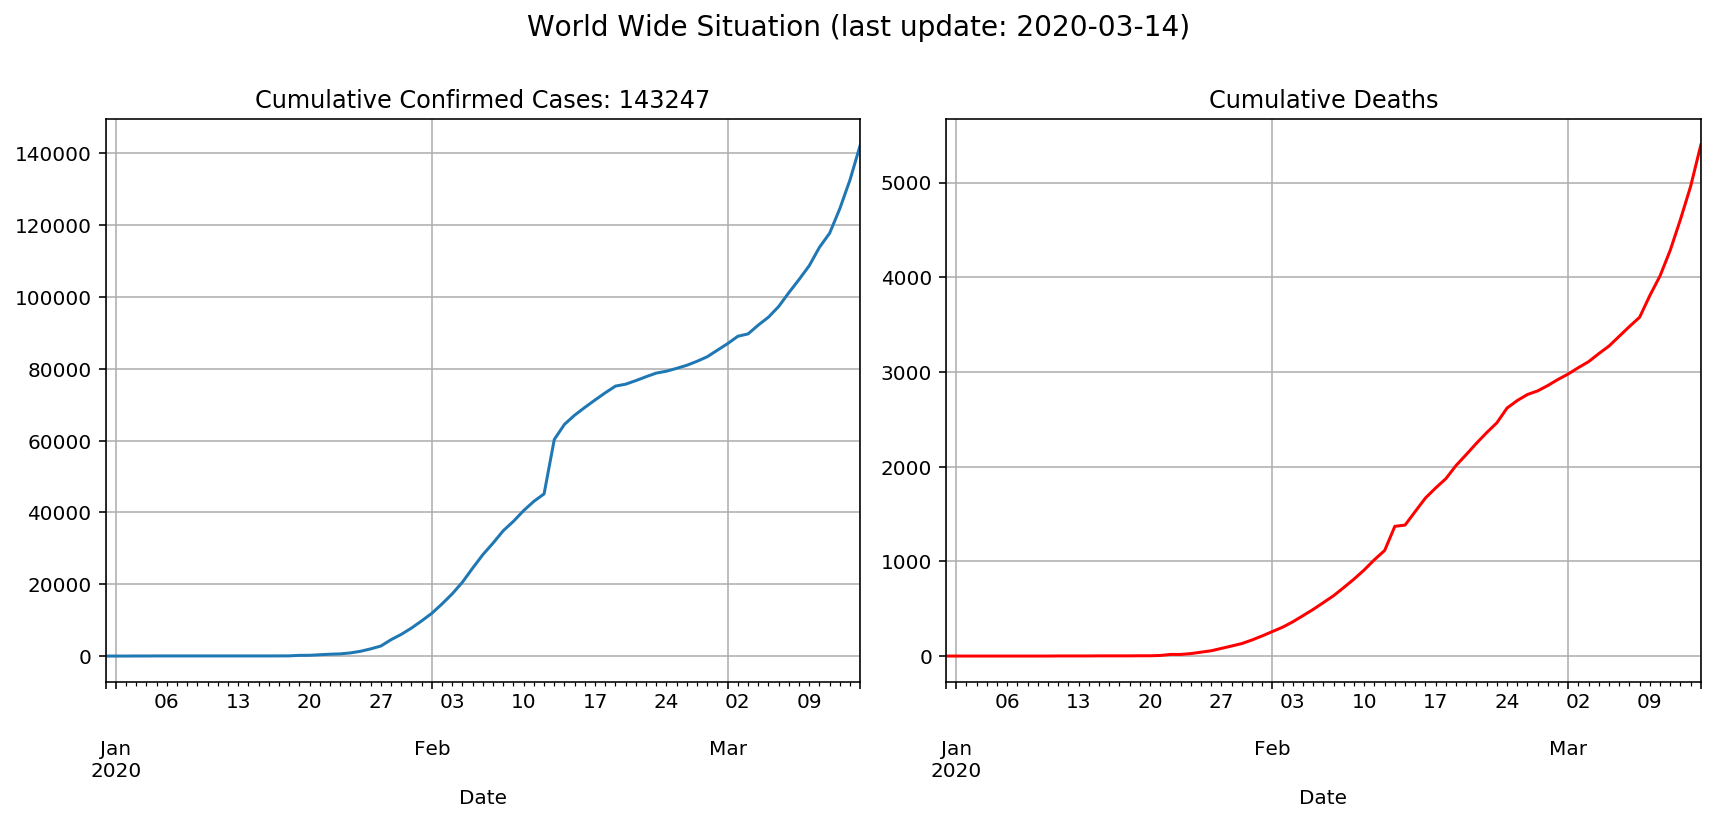

In [152]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle(f'World Wide Situation (last update: {last_av_date_str})', fontsize=14)
cumsum_df.unstack(level=0)[['NewConfCases']].sum(axis=1).plot(ax=ax[0], title=f'Cumulative Confirmed Cases: {confirmed_cases_total}', grid=1)
cumsum_df.unstack(level=0)[['NewDeaths']].sum(axis=1).plot(ax=ax[1], color='red', title='Cumulative Deaths', grid=1);
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.savefig('./_output/pics/total_cumsum.png', dpi=120, bbox='tight')

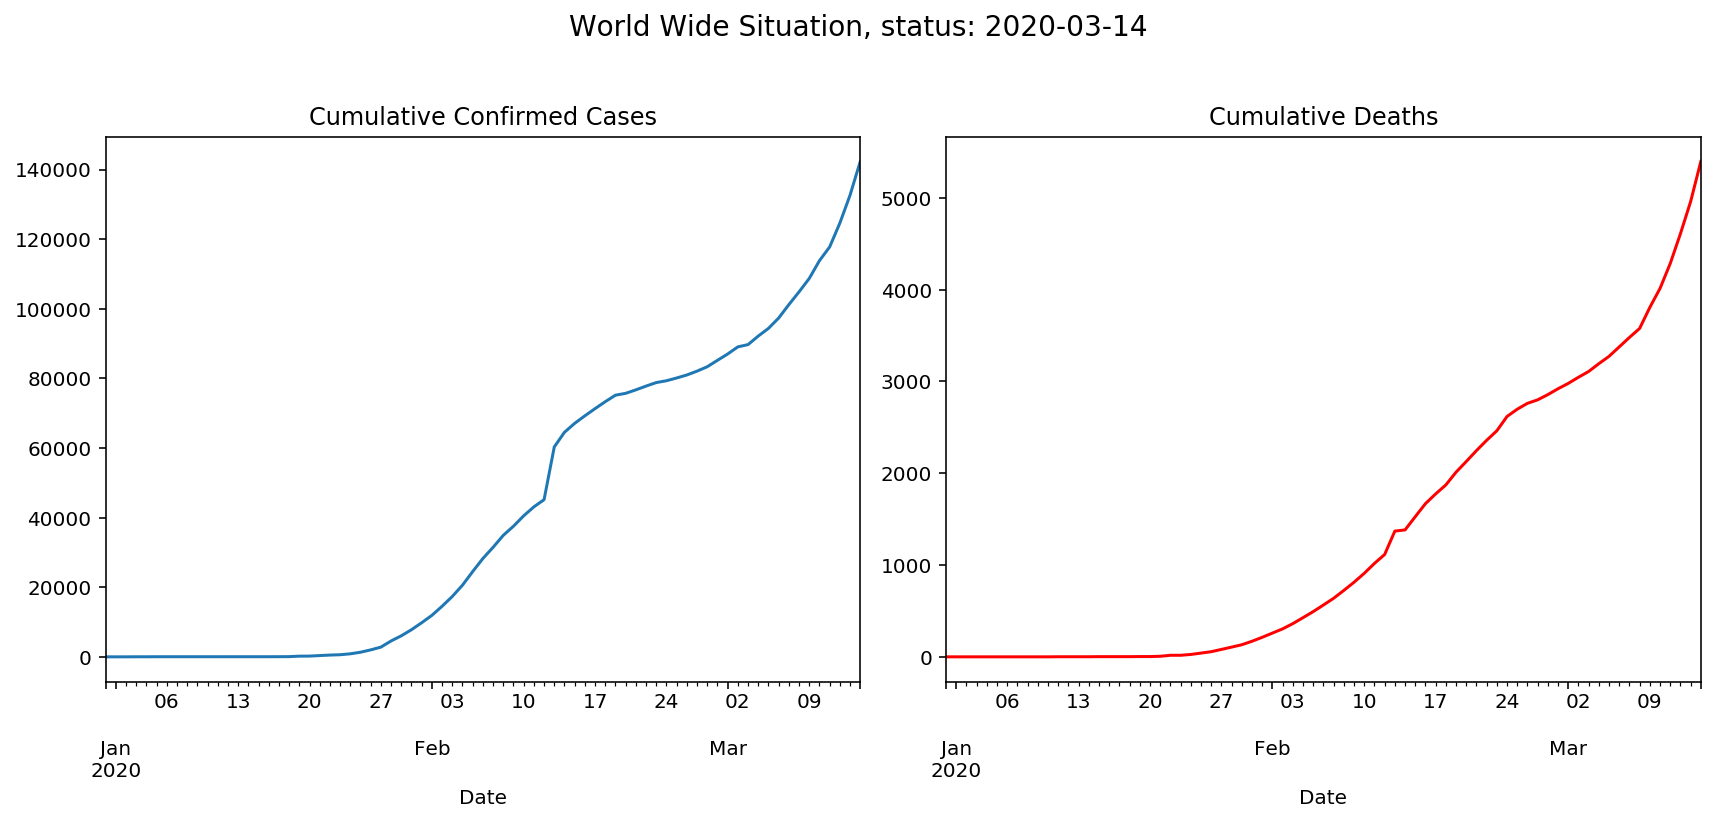

In [90]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.suptitle(f'World Wide Situation, status: {last_av_date_str}', fontsize=14)
cumsum_df.unstack(level=0)[['NewConfCases']].sum(axis=1).plot(ax=ax[0], title='Cumulative Confirmed Cases')
cumsum_df.unstack(level=0)[['NewDeaths']].sum(axis=1).plot(ax=ax[1], color='red', title='Cumulative Deaths');
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

### Concatenating cumulative sum, daily differences and worth factor in a Master DataFrame, df

In [18]:
df = pd.concat({'cumsum' : cumsum_df, 
                'difference' : country_df,
                'growth_factor' : growth_factor_df},axis=1)

In [19]:
# a DataFrame for Switzerland
ch_df = df.loc['Switzerland', idx[:,'NewConfCases']]

In [20]:
def plot_country(df=df, country='Switzerland'):
    
    '''
    For Confirmed and Deaths cases plot cumsum, difference and growth factor
    '''
    
    fig, ax = plt.subplots(3,2, figsize=(10,8))
    c_df = df.loc[country, idx[:,'NewConfCases']]
    
    date_first_case = (c_df.sum(axis=1)!=0).idxmax()
    date_first_case_str = date_first_case.strftime("%Y-%m-%d")
    print(date_first_case_str)
    
    for ith, clm in enumerate(c_df.columns):
        c_df[date_first_case:][[clm]].plot(ax=ax[ith,0])

    c_df = df.loc[country, idx[:,'NewDeaths']]
    for ith, clm in enumerate(c_df.columns):
        c_df[date_first_case:][[clm]].plot(ax=ax[ith,1])

    plt.tight_layout()  


2020-02-26
Switzerland


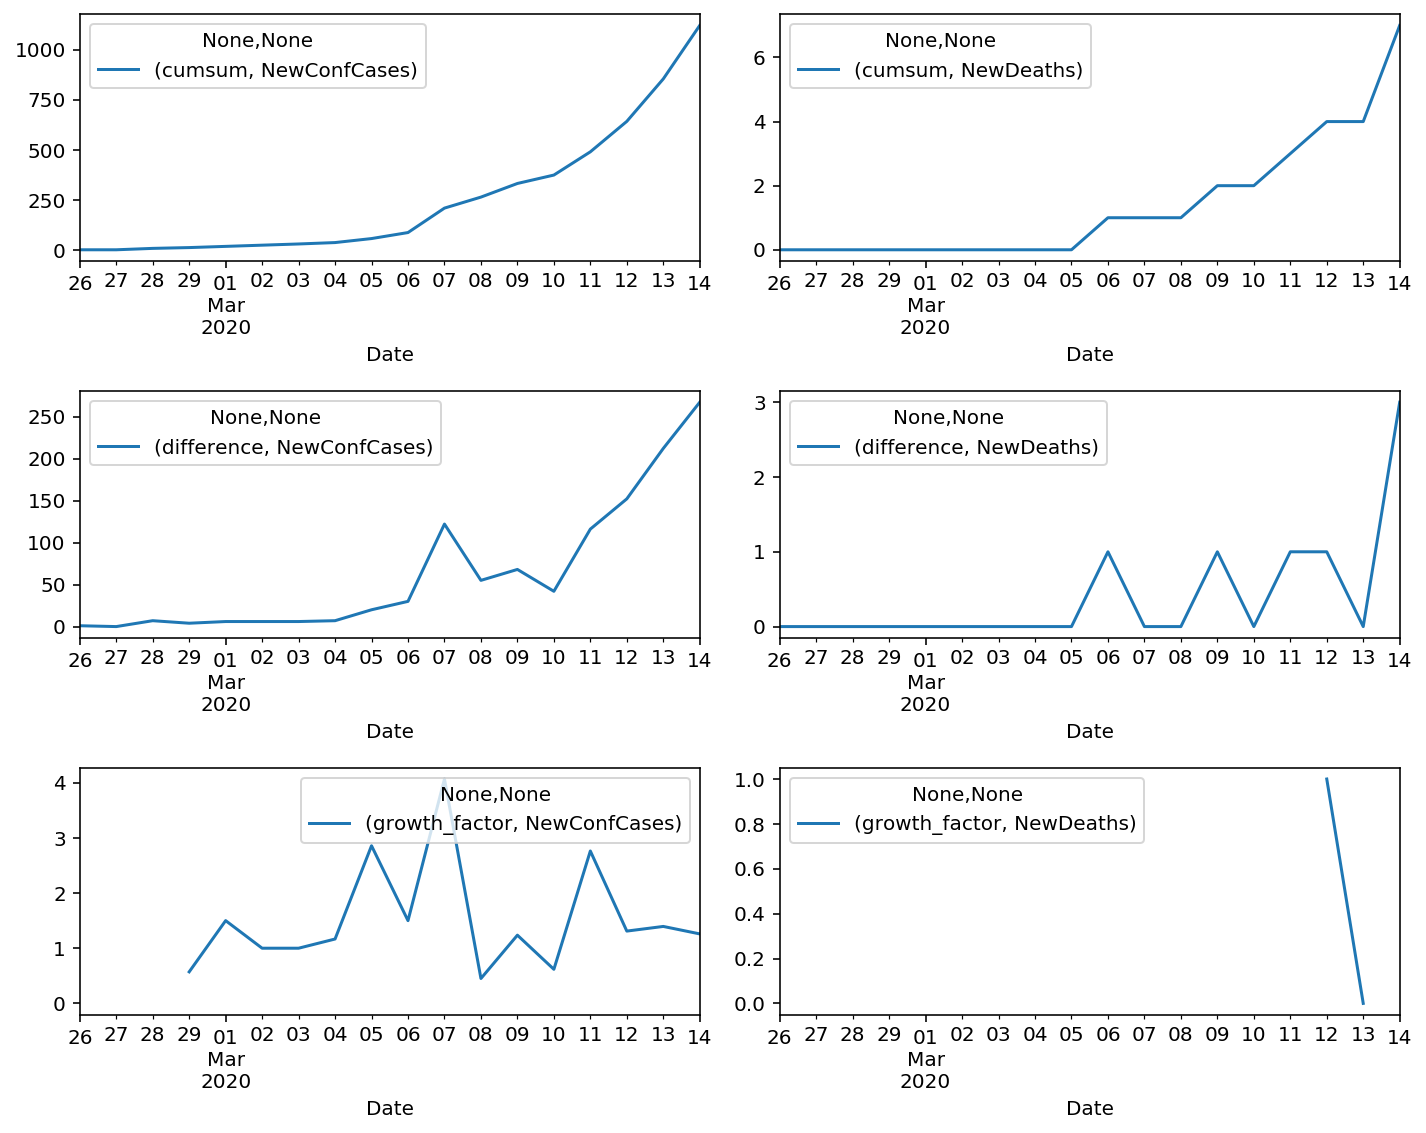

2020-01-31
Italy


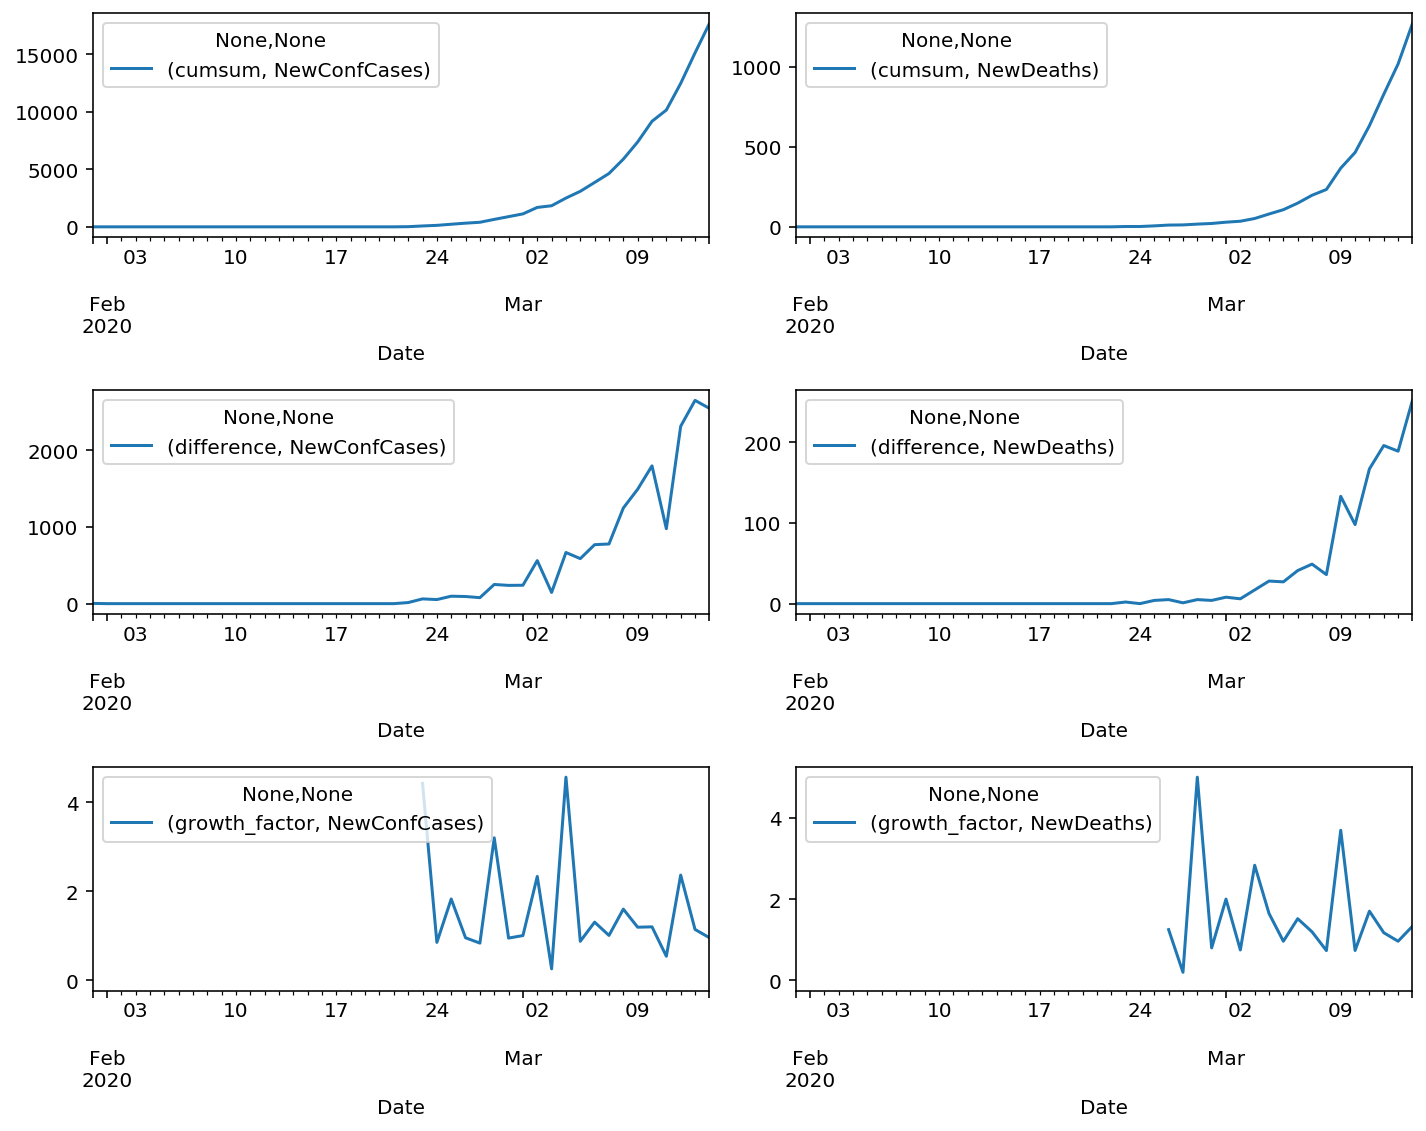

2019-12-31
China


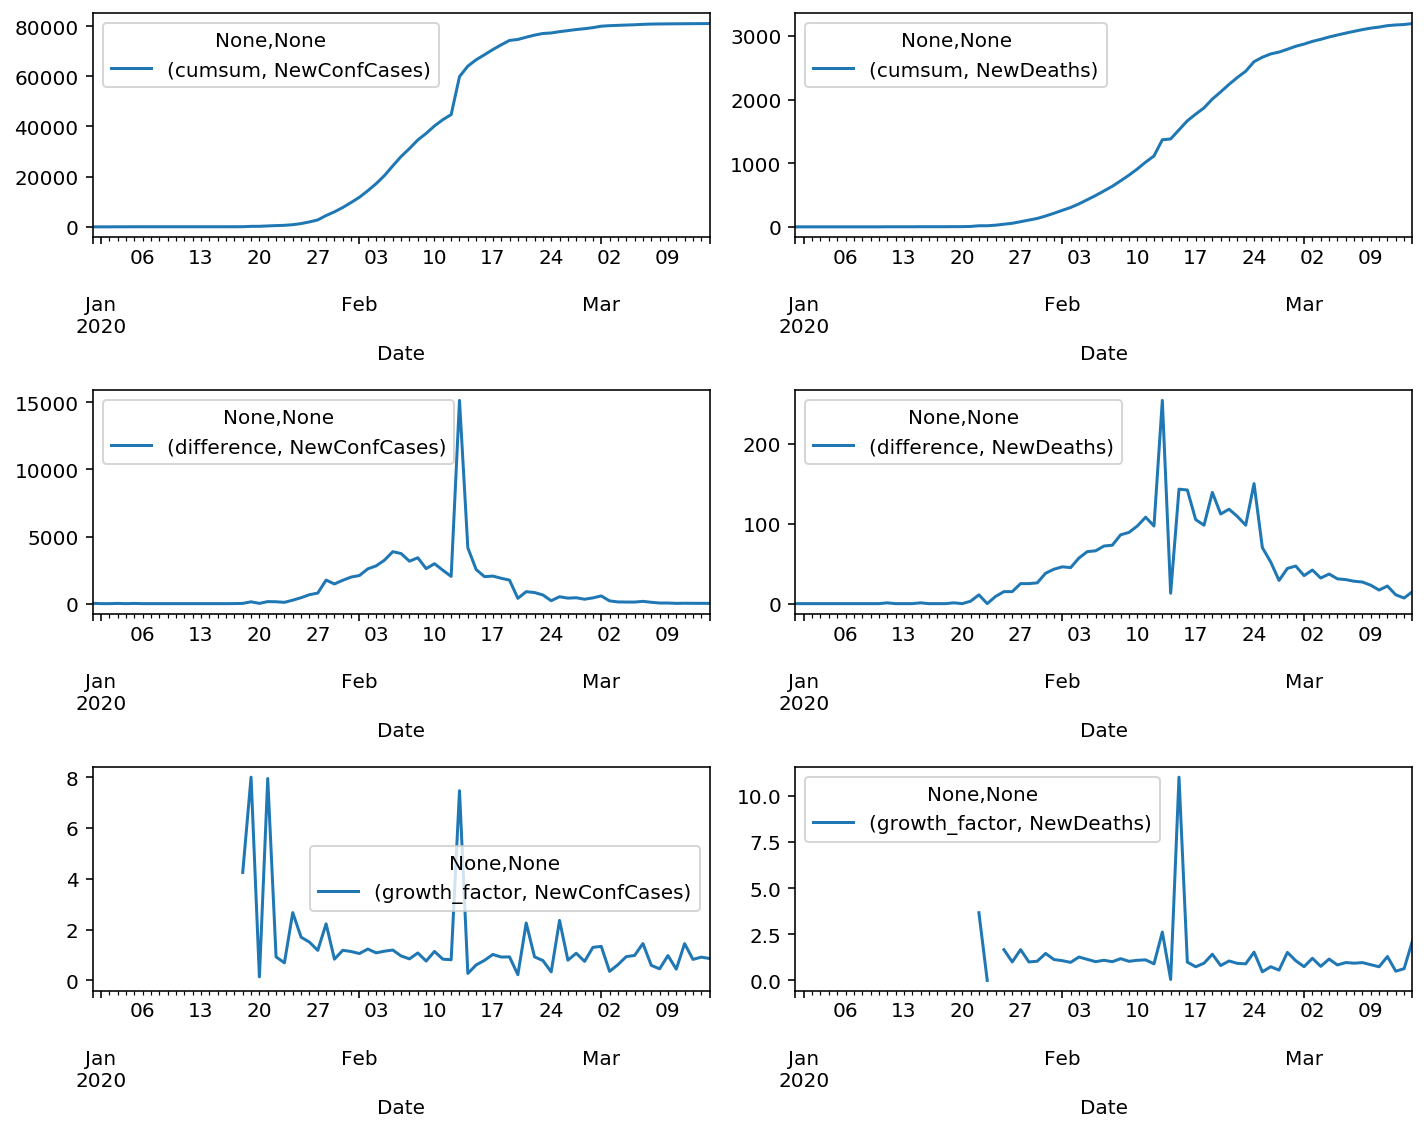

2020-01-15
Japan


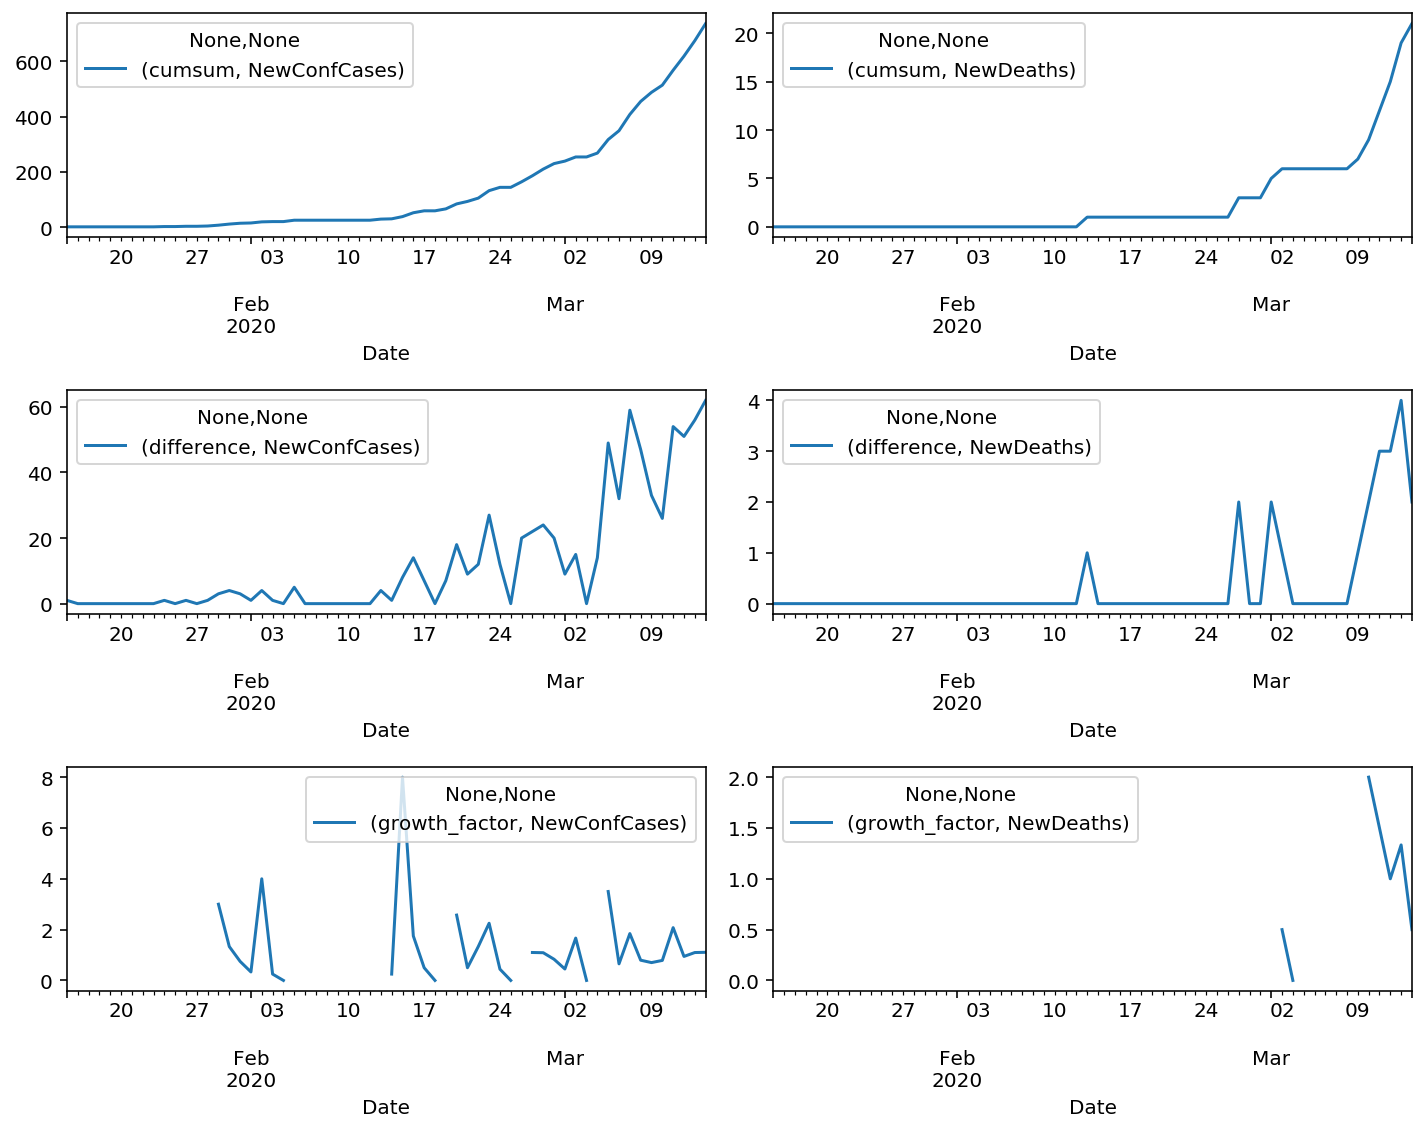

2020-01-20
South Korea


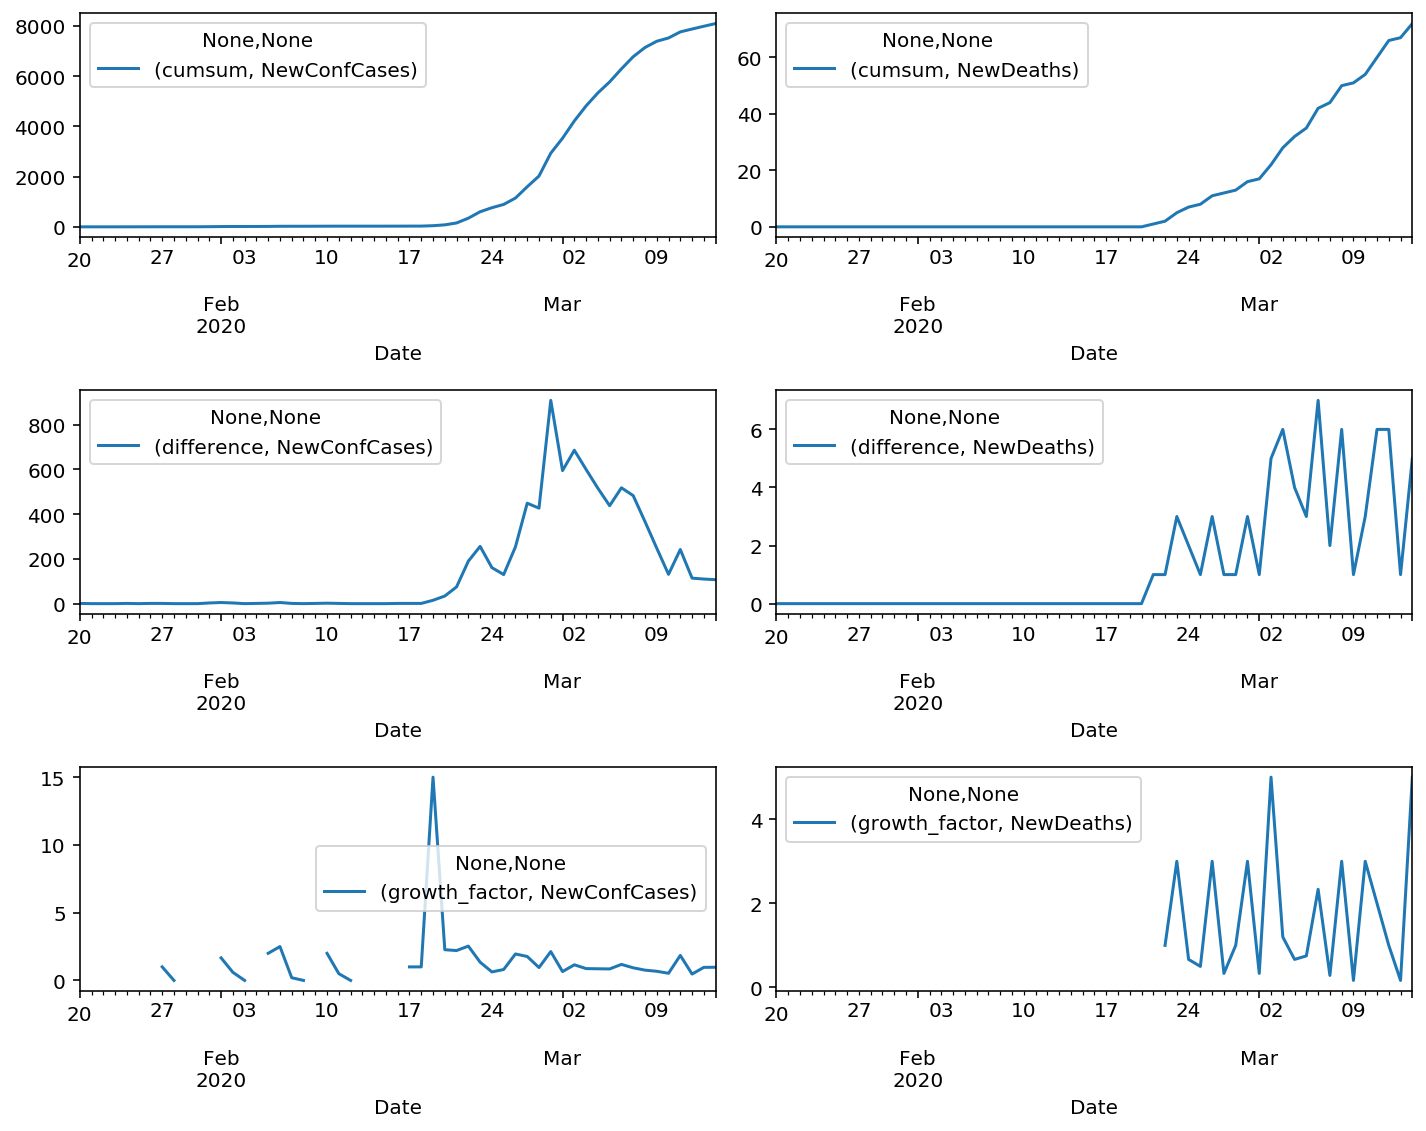

2020-02-20
Iran


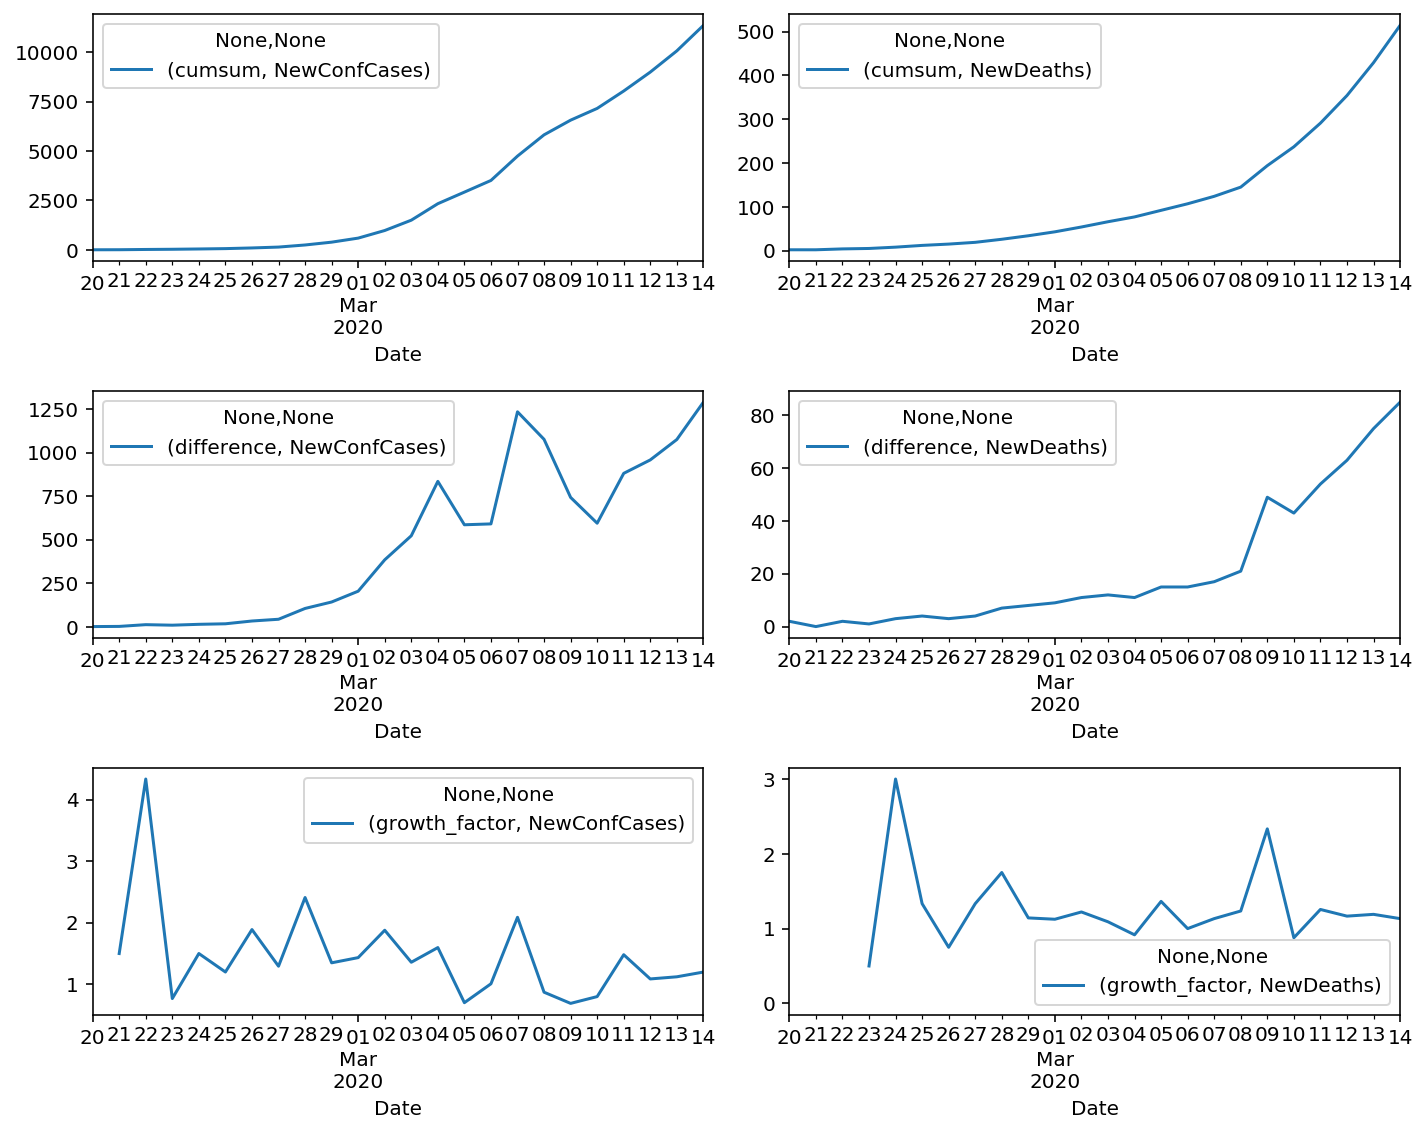

In [21]:
countries = ['Switzerland', 'Italy', 'China', 'Japan', 'South Korea', 'Iran']
for country in countries:
    first_date = plot_country(country=country)
    print(f"{country}")
    plt.show()

### Bar Plot

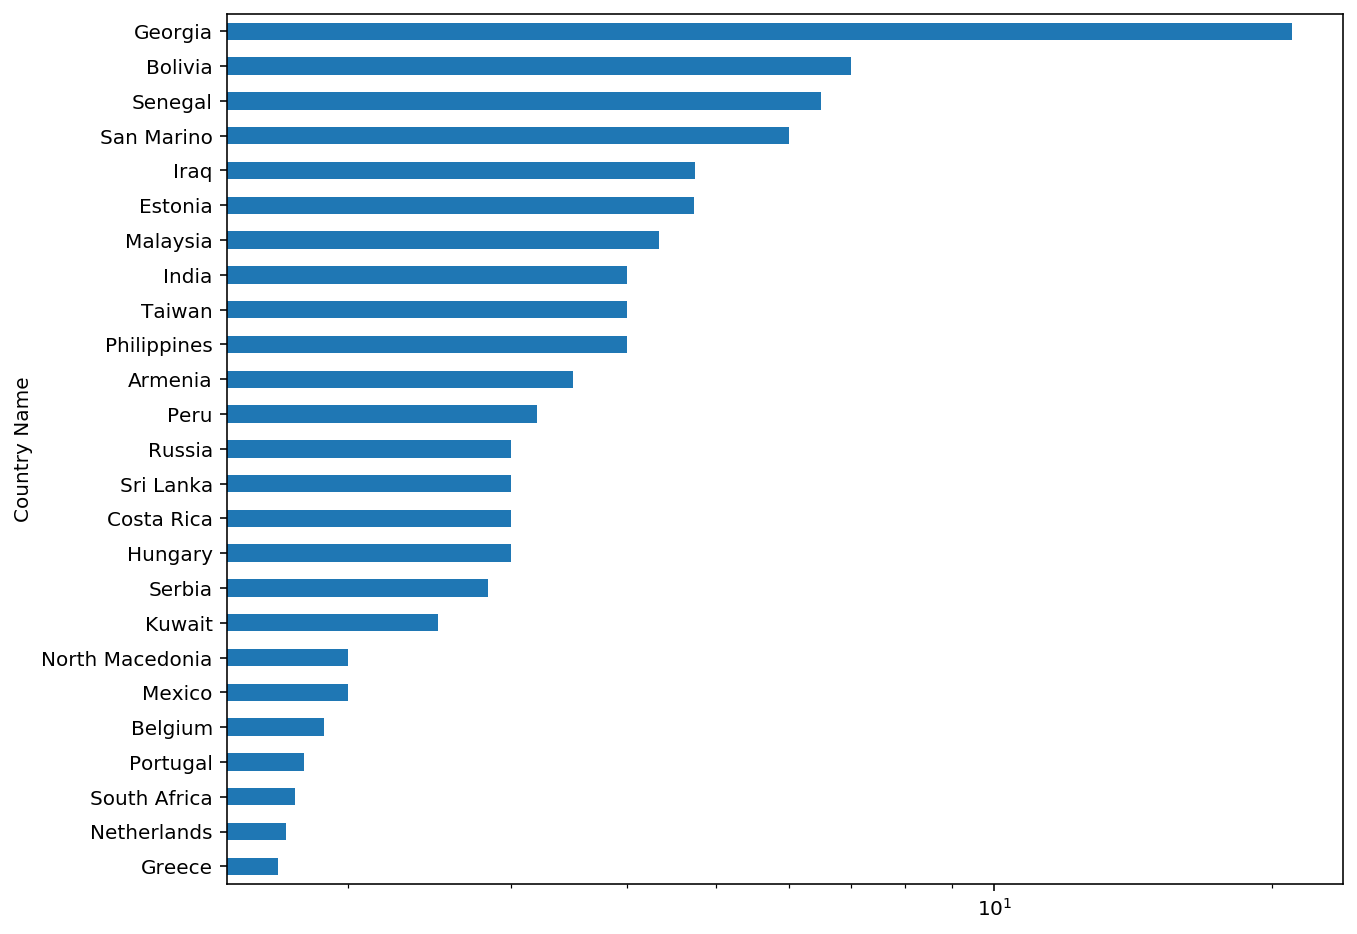

In [78]:
last_av_date = df.index.levels[1][-1]
last_date_df = df.swaplevel(axis=0).sort_index().loc[last_av_date]
last_av_date_str = last_av_date.strftime('%Y-%m-%d') #for later use as a string for plot titles

last_date_df['growth_factor', 'NewConfCases'].sort_values(ascending=False).head(25).plot(kind='barh', figsize=(10,8), logx=True).invert_yaxis()

### High Growth Factor Countries for last available date

2020-02-27
Georgia


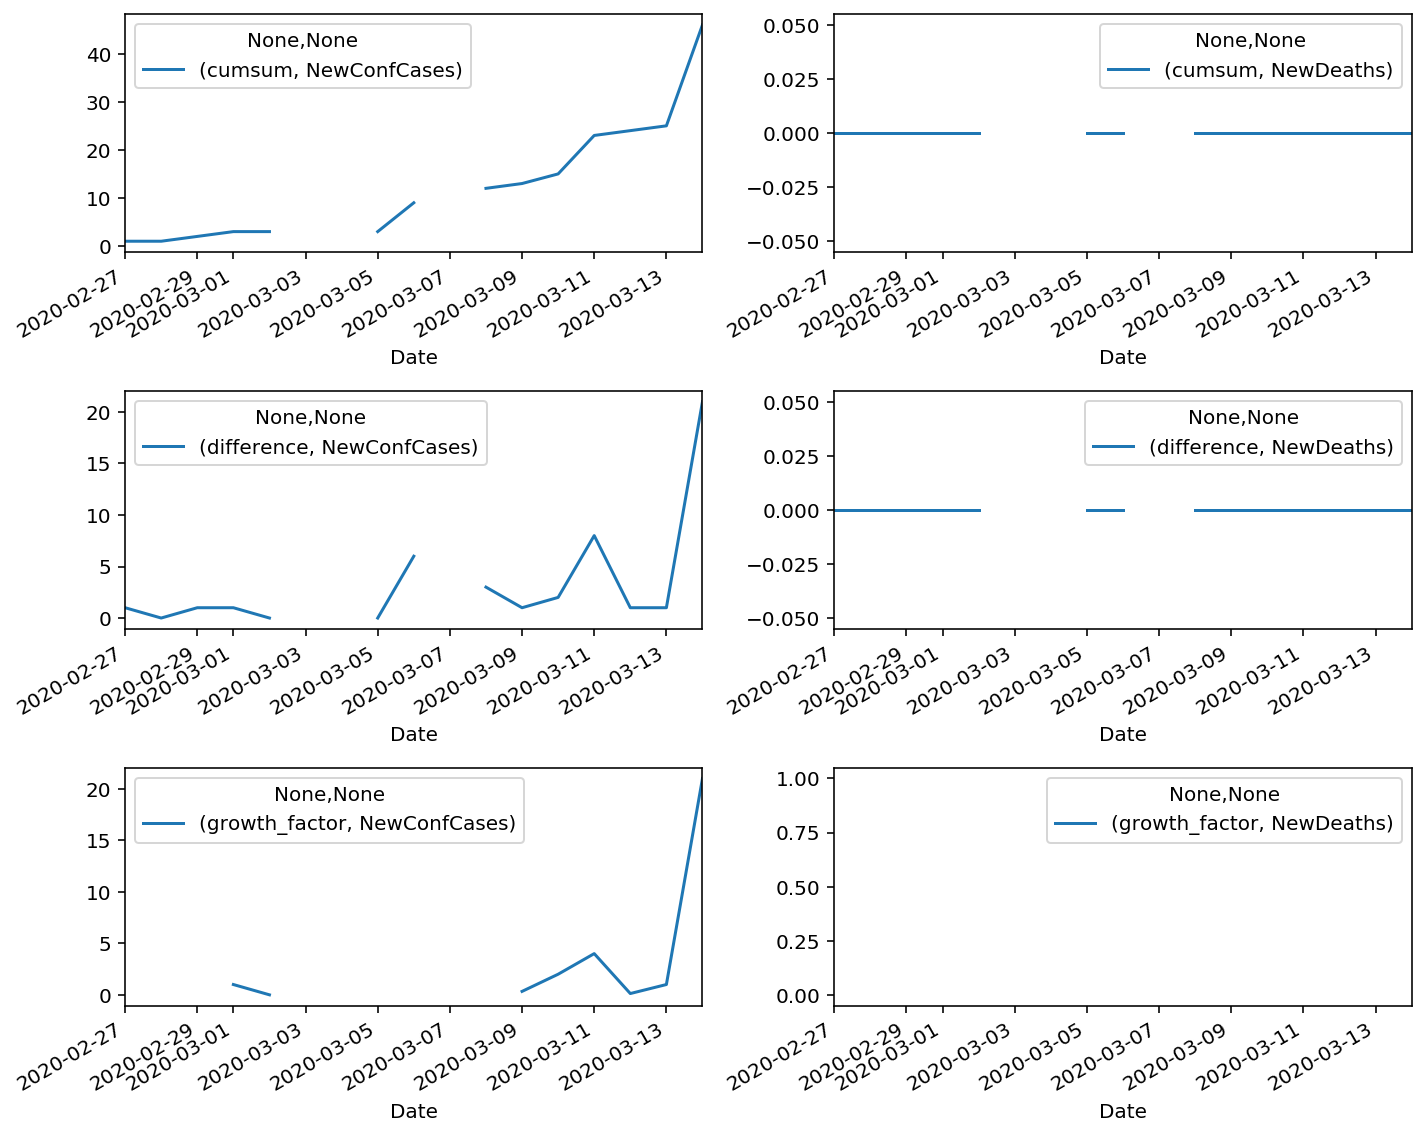

2020-03-12
Bolivia


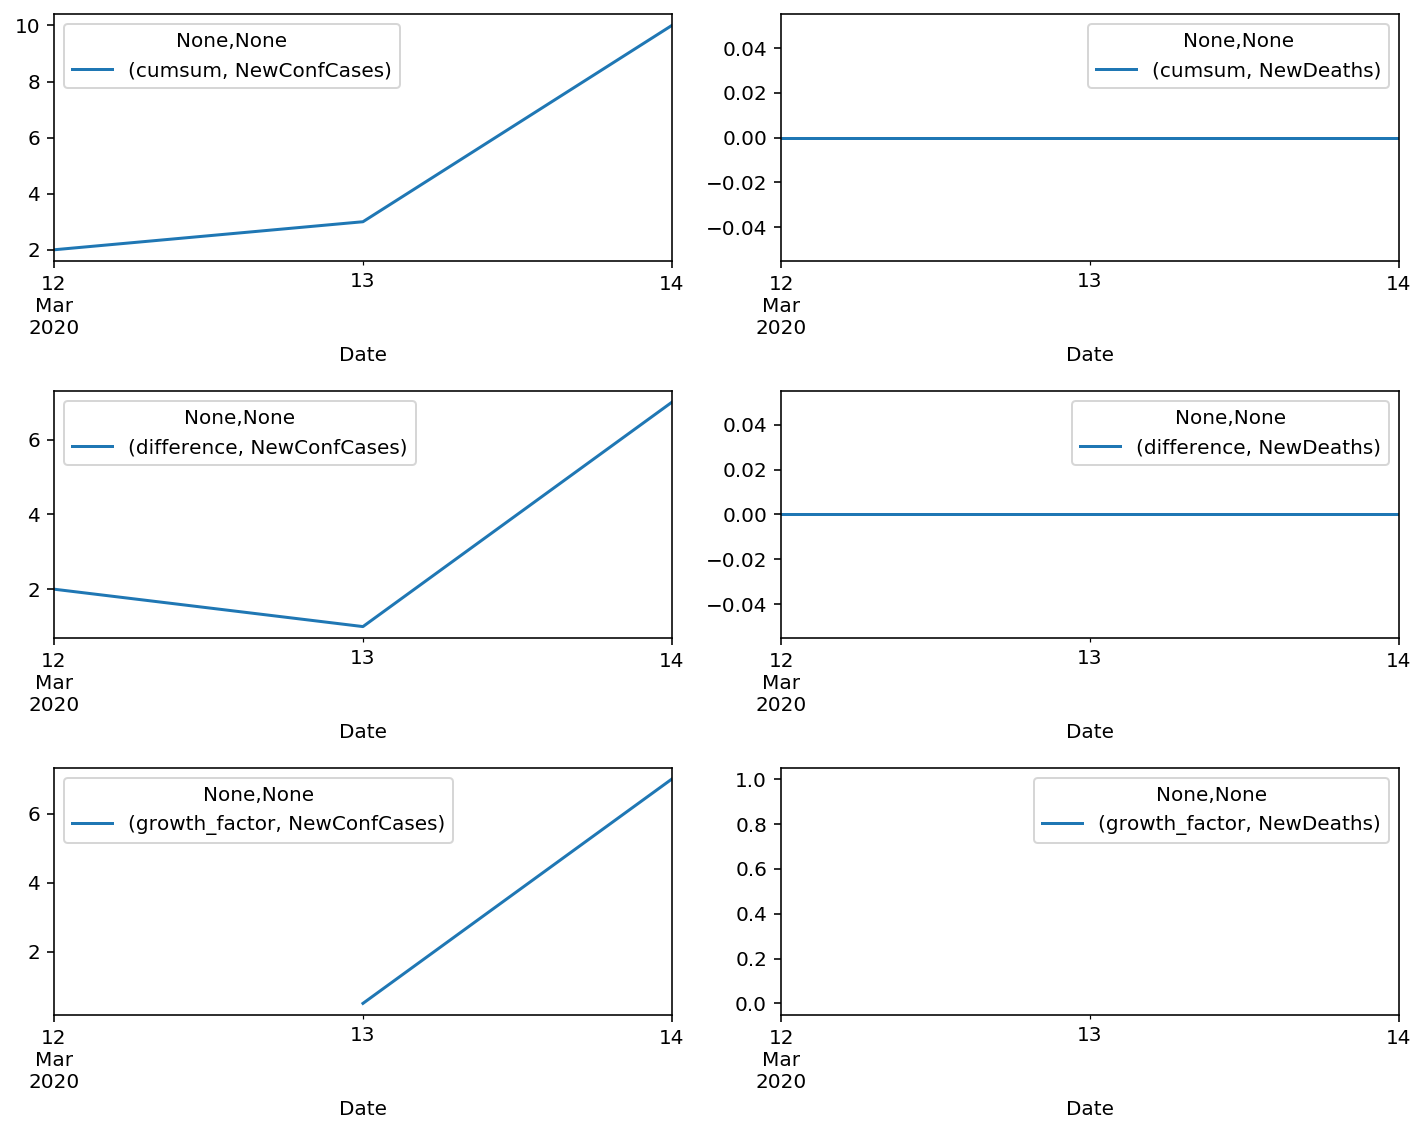

2020-03-03
Senegal


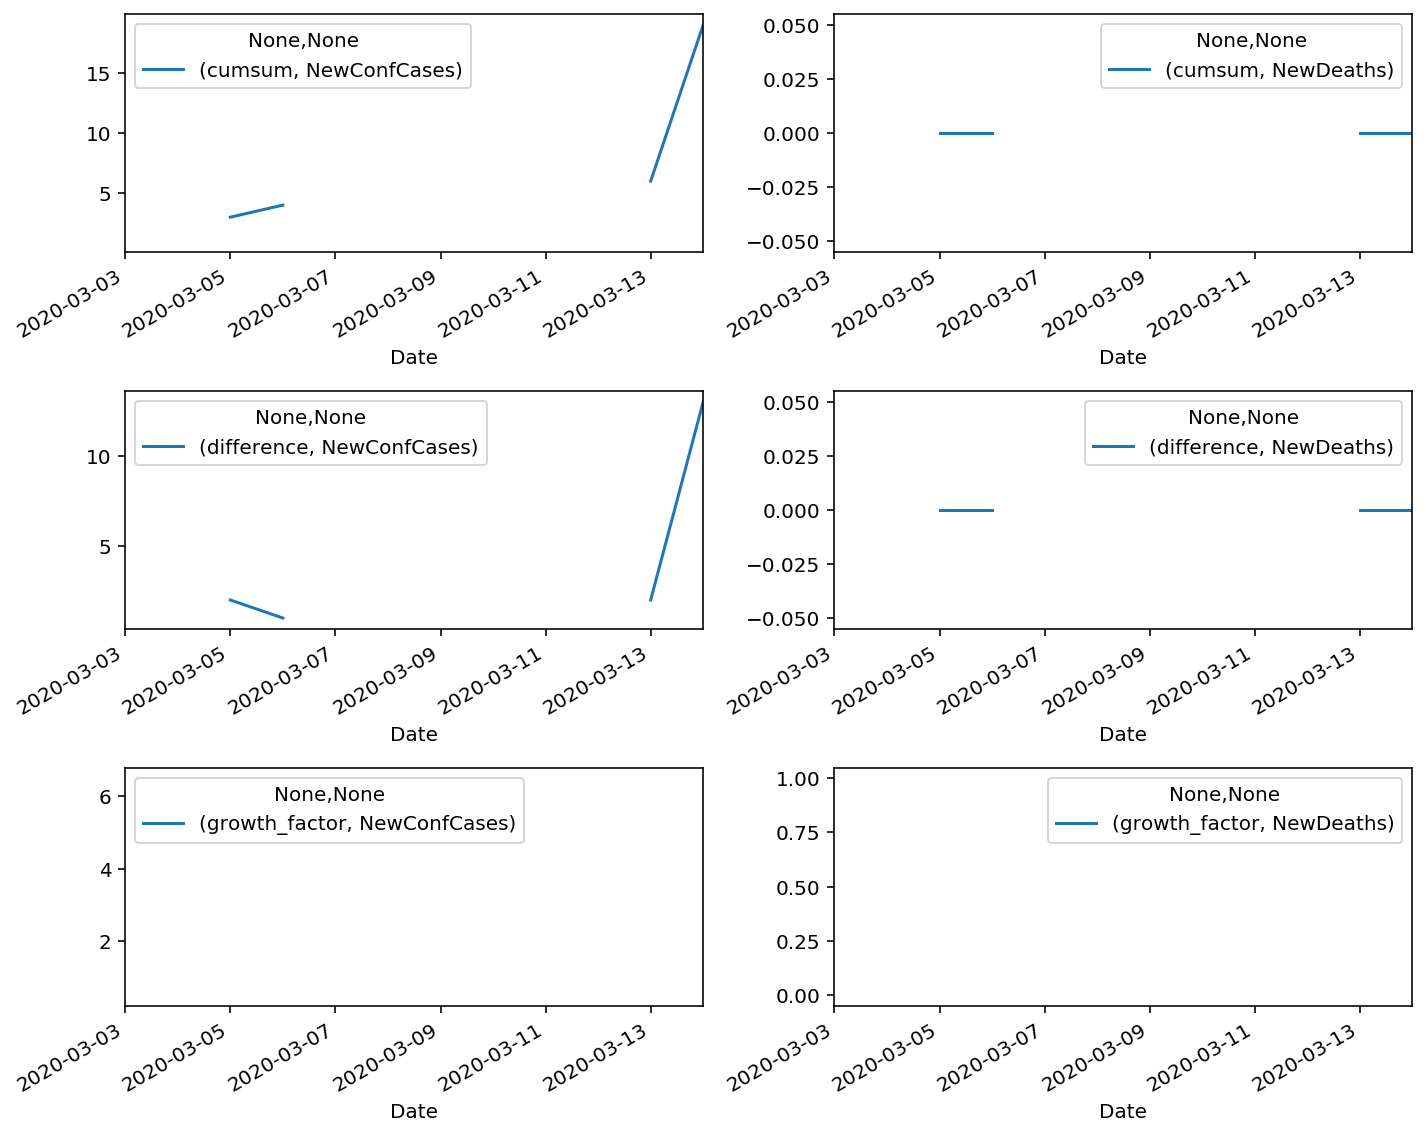

2020-02-28
San Marino


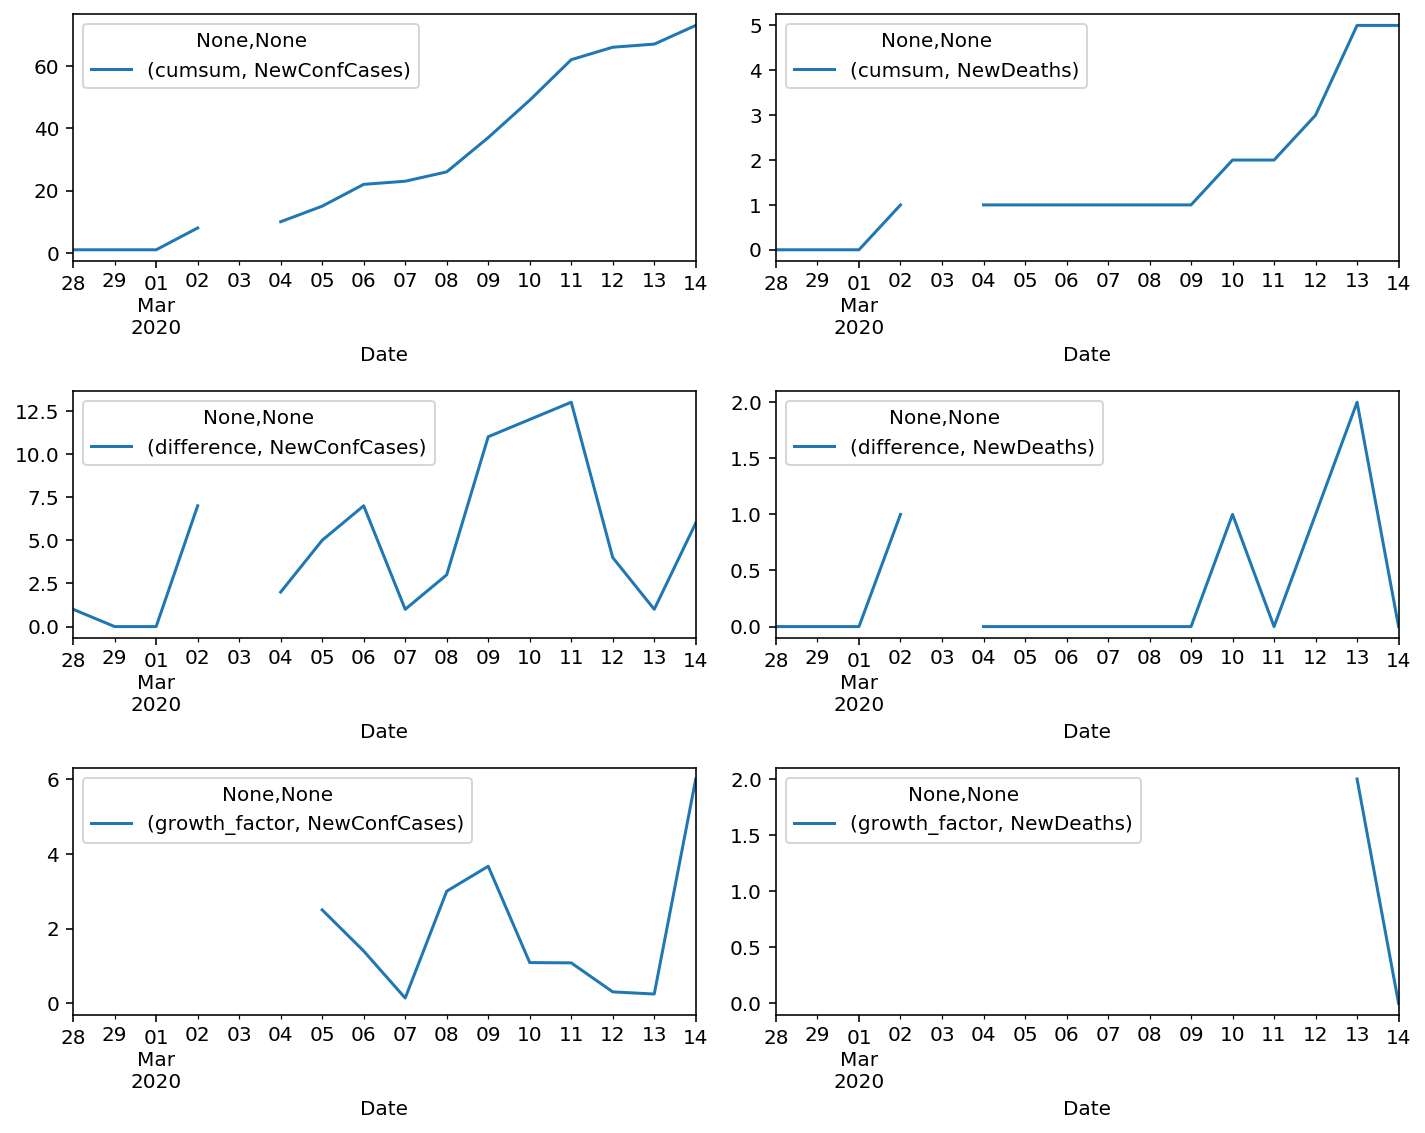

2020-02-25
Iraq


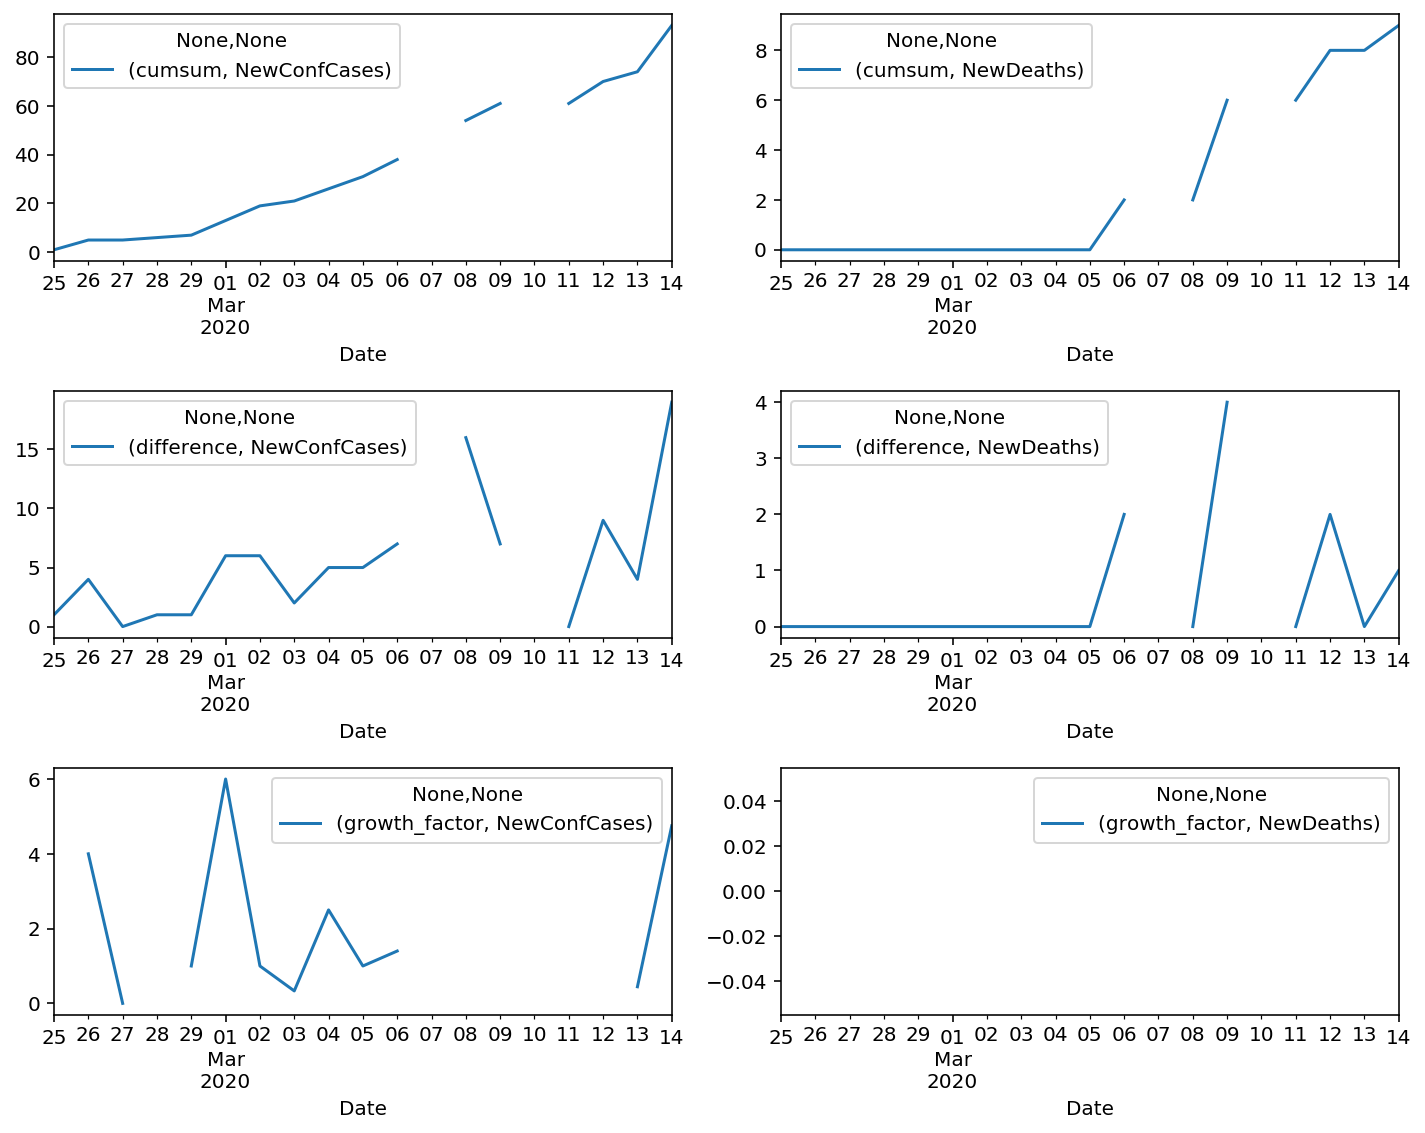

In [24]:
hi_growth = list(last_date_df['growth_factor', 'NewConfCases'].sort_values(ascending=False).head(5).index)
countries = hi_growth
for country in countries:
    first_date = plot_country(country=country)
    print(f"{country}")
    plt.show()

## start point, day with first confirmed case

In [129]:
def plot_country_dayone(df=df, thresh=1, countries=['Switzerland', 'Italy', 'France', 'Germany', 'United Kingdom', 'South Korea', 'China', 'Poland', 'Russia', 'United States Of America'], legend=True, lw=4, clmn_name='NewConfCases'):
    '''
    plot cumulative confirmed cases starting from first date compliant with the min case threshold
    process non-weighted and weighted cases
    
    Params:
    -------
    df: pandas DataFrame, COVID dataframe
    thresh: int, min number of cumulative cases for plotting; if not met, the country is skipped
    countries: list, list of countries to plot
    
    Return: logy scaled cumulative sum of confirmed cases
    -------
    '''
    
    fig, ax = plt.subplots(figsize=(8,7))
    
    #defining the title now, before modifying thresh
    print_thresh = thresh
    count_plotted = 0 #variable used to count the number of plotted curves in order to set legend clm number correctly
    
    if thresh >= 1:
        # subtract 1, only if thresh is referred to non-weighted values
        plt.title(f'Cumulative Confirmed Cases, from {print_thresh} case(s)')
        thresh = thresh-1
    else:
        plt.title(f'Per Capita Cumulative Confirmed Cases, from 1 every {int(np.ceil(print_thresh**(-1))):,} case(s)')

    
    for country in countries:
    
        c_df = df.loc[country, idx[:,clmn_name]]
        
        #checking if the specific country has reached thresh
        if (c_df['cumsum'].sum(axis=1)>thresh).sum()>0:
            date_first_case = (c_df['cumsum'].sum(axis=1)>thresh).idxmax() #identifying first date with 1 case
            
            days = c_df.loc[date_first_case:,'cumsum'].size

            c_cumsum_df = c_df.loc[date_first_case:,'cumsum']
            c_cumsum_df['day'] = np.arange(1,days+1,1)

            c_cumsum_df.reset_index().set_index(['day'])[[clmn_name]].rename({clmn_name:country},axis=1)\
                       .plot(ax=ax, logy=True, lw=lw, alpha=.8)
            
            count_plotted+=1
            
        else:
            print(f"{country} hasn't reached specified threshold of {print_thresh} confirmed case(s)'")

    plt.grid(True, which='minor')
    plt.xlabel('Days (after min threshold)')
    plt.ylabel('Cumulative Confirmed Cases')

    if len(countries) > 8:
        plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.), ncol=int(np.ceil(count_plotted/25)))

    if legend == False:
        ax.legend().set_visible(False)



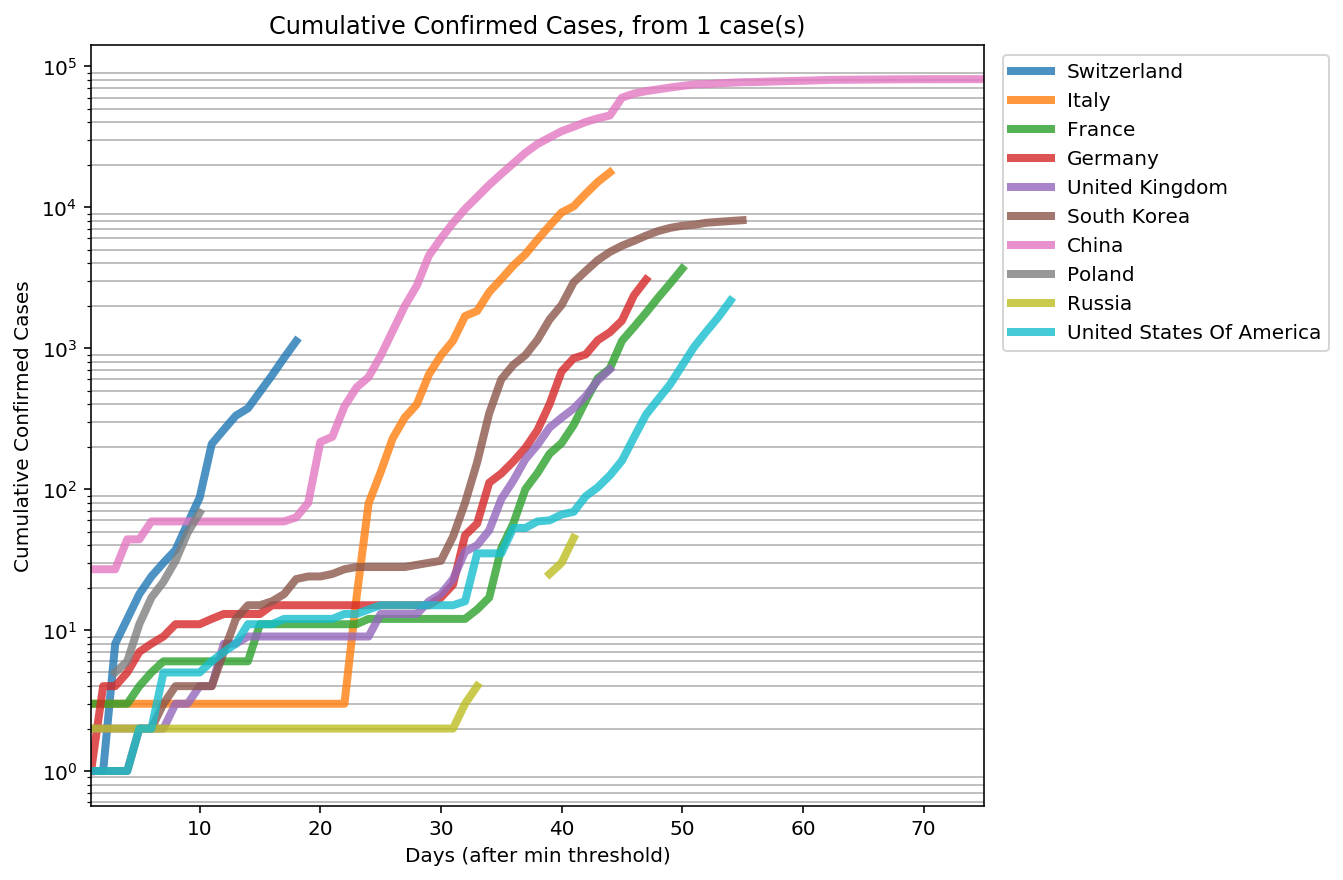

In [130]:
plot_country_dayone(thresh=1)

Poland hasn't reached specified threshold of 100 confirmed case(s)'
Russia hasn't reached specified threshold of 100 confirmed case(s)'


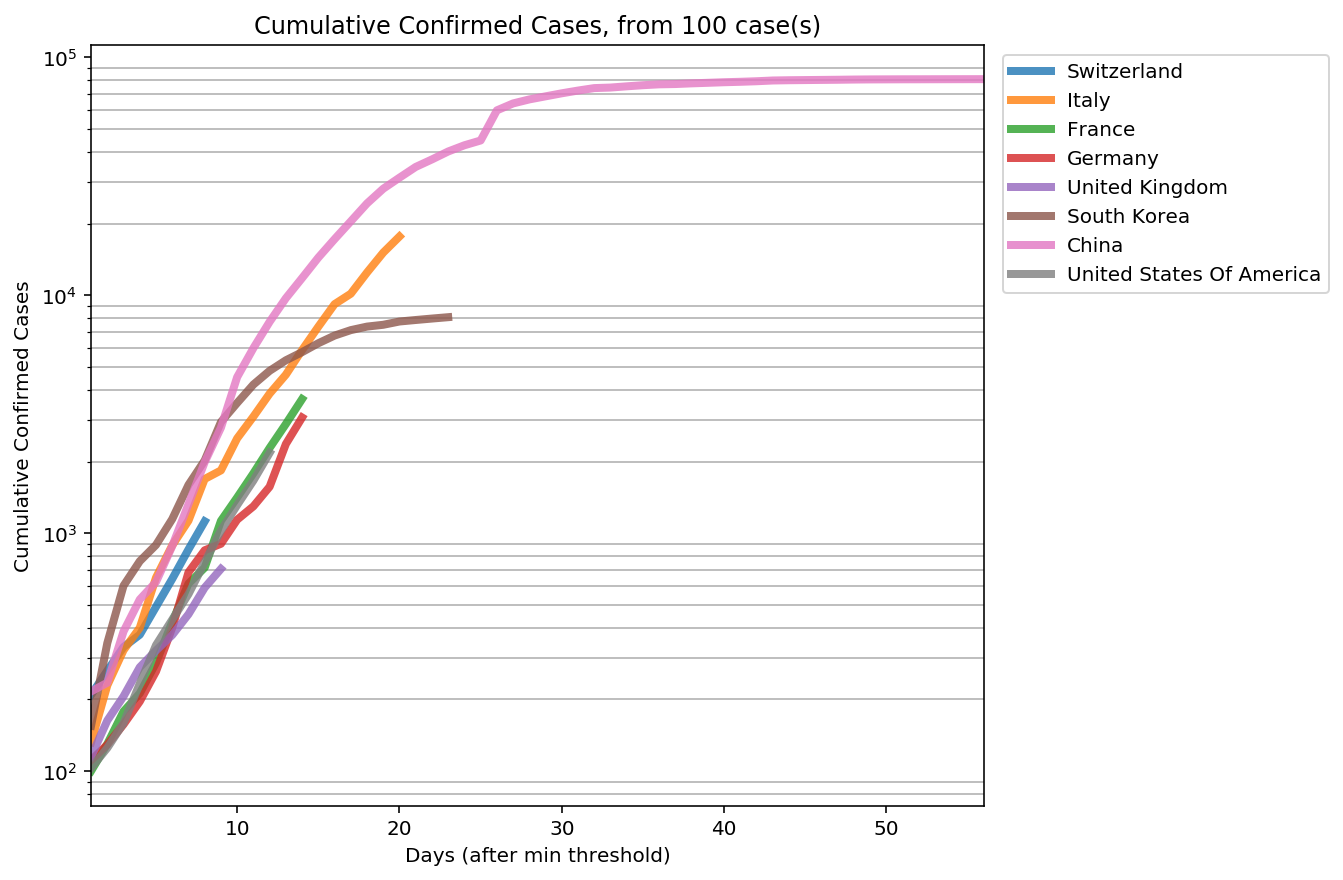

In [131]:
plot_country_dayone(thresh=100)
plt.savefig('./_output/pics/cumsum_cases.png', dpi=125, bbox_inches = 'tight')

Afghanistan hasn't reached specified threshold of 100 confirmed case(s)'
Albania hasn't reached specified threshold of 100 confirmed case(s)'
Algeria hasn't reached specified threshold of 100 confirmed case(s)'
Andorra hasn't reached specified threshold of 100 confirmed case(s)'
Argentina hasn't reached specified threshold of 100 confirmed case(s)'
Armenia hasn't reached specified threshold of 100 confirmed case(s)'
Azerbaijan hasn't reached specified threshold of 100 confirmed case(s)'
Bangladesh hasn't reached specified threshold of 100 confirmed case(s)'
Belarus hasn't reached specified threshold of 100 confirmed case(s)'
Bhutan hasn't reached specified threshold of 100 confirmed case(s)'
Bolivia hasn't reached specified threshold of 100 confirmed case(s)'
Bosnia And Herzegovina hasn't reached specified threshold of 100 confirmed case(s)'
Brazil hasn't reached specified threshold of 100 confirmed case(s)'
Brunei Darussalam hasn't reached specified threshold of 100 confirmed case(s)'

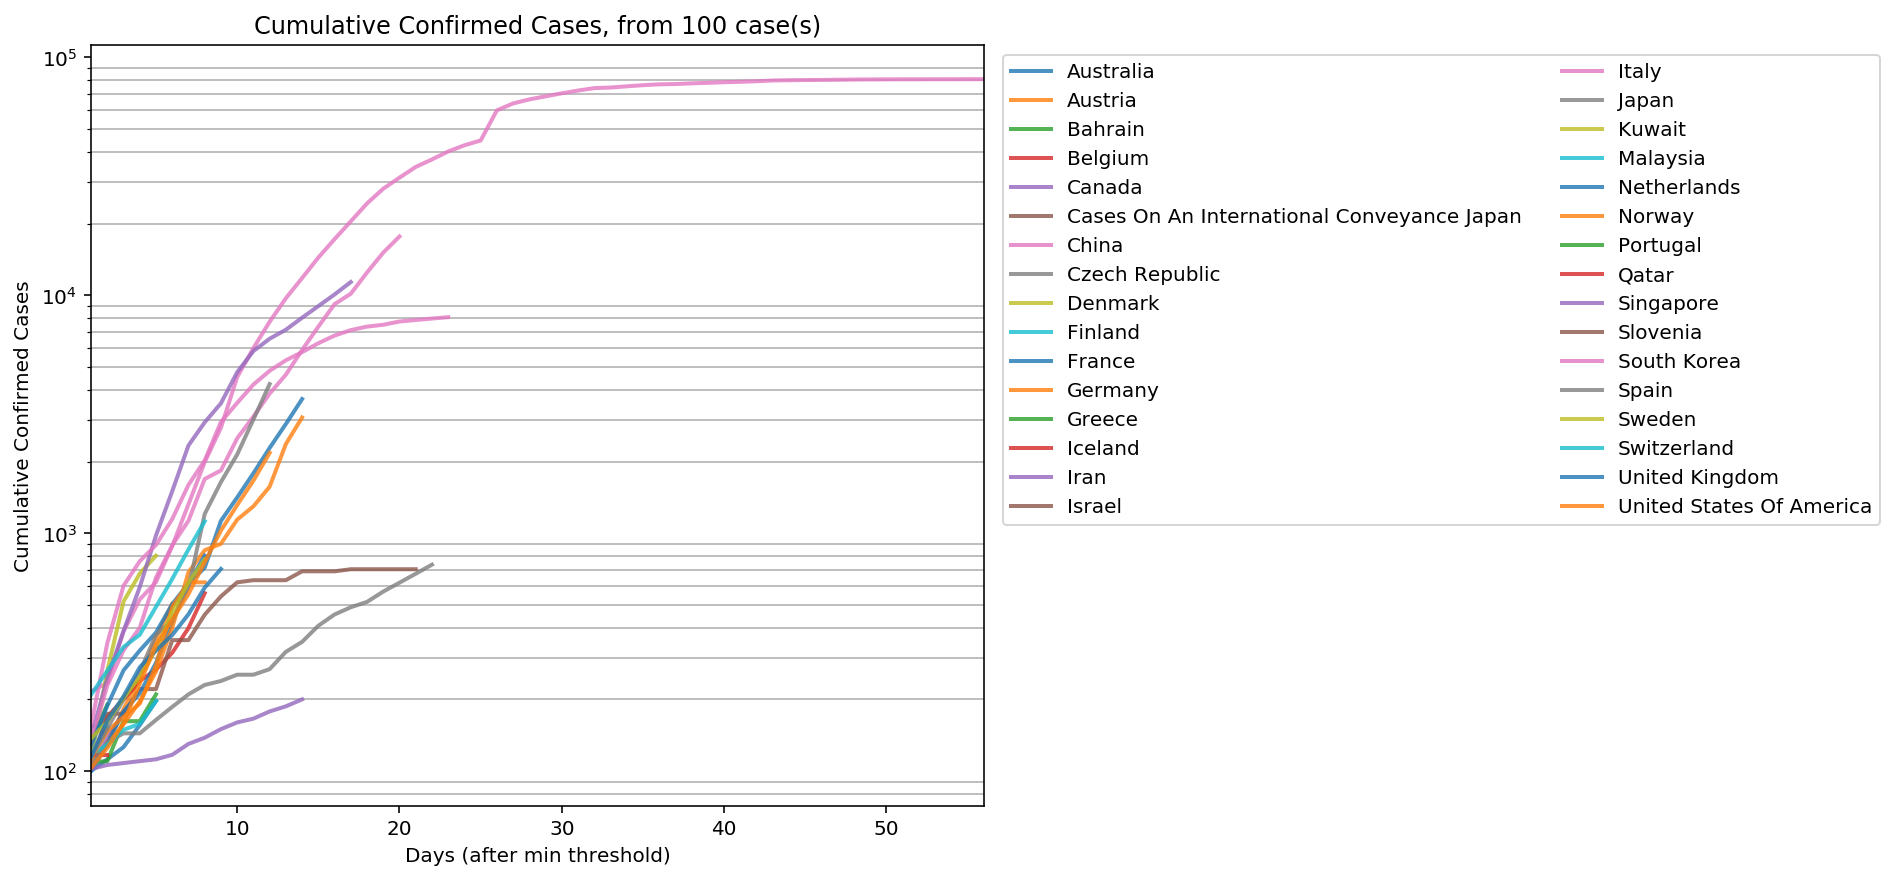

In [28]:
plot_country_dayone(thresh=100, countries=countries_lst, legend=True, lw=2)

# Cases Per Capita

In [29]:
pop_df = pd.read_csv('./_input/02_world_population/API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv',header=2)
# slicing out only the clmns I need
clms = list(pop_df.columns[:])
clmns = clms[:4]
clmns.append(clms[-3]) #appending last clmn, 2018, to previous items list
#clmns
pop_df = pop_df[clmns].set_index('Country Name')
pop_df.rename({pop_df.columns[-1] : 'pop_2018'}, axis=1, inplace=True)
pop_df.head()

,Country Code,Indicator Name,Indicator Code,pop_2018
Country Name,,,,
Aruba,ABW,"Population, total",SP.POP.TOTL,105845.0
Afghanistan,AFG,"Population, total",SP.POP.TOTL,37172386.0
Angola,AGO,"Population, total",SP.POP.TOTL,30809762.0
Albania,ALB,"Population, total",SP.POP.TOTL,2866376.0
Andorra,AND,"Population, total",SP.POP.TOTL,77006.0


In [30]:
# renaming some countries to match df naming
## 
country_dict = {'United States' : 'United States Of America', 
 "Cote d'Ivoire" : 'Cote Divoire',
 'Czech republic' : 'Czech Republic', 
 'Congo, Dem. Rep.' : 'Democratic Republic Of The Congo', 
 'Egypt, Arab Rep.' : 'Egypt',
 'Iran, Islamic Rep.' : 'Iran',
 'Russian Federation' : 'Russia',
 'Slovak Republic' : 'Slovakia',
 'Korea, Rep.' : 'South Korea',
 'Bosnia and Herzegovina' : 'Bosnia And Herzegovina',
 'St. Vincent and the Grenadines' : 'Saint Vincent And The Grenadines', 
 'Trinidad and Tobago': 'Trinidad And Tobago'} 

# found in pop_df but NA in df 
#'Palestine' : '',
#'Taiwan' : '',

In [31]:
pop_df.reset_index(inplace=True)
pop_df['Country Name'] = pop_df['Country Name'].replace(country_dict)
pop_df.set_index('Country Name', inplace=True)
pop_df.head()

,Country Code,Indicator Name,Indicator Code,pop_2018
Country Name,,,,
Aruba,ABW,"Population, total",SP.POP.TOTL,105845.0
Afghanistan,AFG,"Population, total",SP.POP.TOTL,37172386.0
Angola,AGO,"Population, total",SP.POP.TOTL,30809762.0
Albania,ALB,"Population, total",SP.POP.TOTL,2866376.0
Andorra,AND,"Population, total",SP.POP.TOTL,77006.0


> countries missing in df

In [32]:
df.index.levels[0].name = 'Country Name'

In [33]:
df

cumsum             difference            \
                        NewConfCases NewDeaths NewConfCases NewDeaths   
Country Name Date                                                       
Afghanistan  2019-12-31          0.0       0.0          0.0       0.0   
             2020-01-01          0.0       0.0          0.0       0.0   
             2020-01-02          0.0       0.0          0.0       0.0   
             2020-01-03          0.0       0.0          0.0       0.0   
             2020-01-04          0.0       0.0          0.0       0.0   
...                              ...       ...          ...       ...   
Vietnam      2020-03-10         31.0       0.0          1.0       0.0   
             2020-03-11         35.0       0.0          4.0       0.0   
             2020-03-12         39.0       0.0          4.0       0.0   
             2020-03-13         44.0       0.0          5.0       0.0   
             2020-03-14         49.0       0.0          5.0       0.0   

                        growth_factor            
                         NewConfCases NewDeaths  
Country Name Date                                
Afghanistan  2019-12-31           NaN       NaN  
             2020-01-01           NaN       NaN  
             2020-01-02           NaN       NaN  
             2020-01-03           NaN       NaN  
             2020-01-04           NaN       NaN  
...                               ...       ...  
Vietnam      2020-03-10      0.111111       NaN  
             2020-03-11      4.000000       NaN  
             2020-03-12      1.000000       NaN  
             2020-03-13      1.250000       NaN  
             2020-03-14      1.000000       NaN  

[5168 rows x 6 columns]

In [34]:
#joining covid data with country population

j_df = df.stack(level=0).join(pop_df, how='inner') #joining on inner, non matching indeces will be discarded 
j_df = j_df.loc[idx[:,:,'cumsum'],:] #weighting against population makes sense only for cumsum

In [35]:
# weighting data by population
j_df[['w_NewConfCases', 'w_NewDeaths']] = j_df[['NewConfCases', 'NewDeaths']].divide(j_df.loc[idx[:,:,'cumsum'],'pop_2018'], axis=0)

In [36]:
w_df = j_df[j_df.columns[j_df.columns.str.contains('w_')]].unstack(level=2).swaplevel(axis=1).copy()
w_df.rename(columns={'cumsum' : 'w_cum'})

w_cum            
                        w_NewConfCases w_NewDeaths
Country Name Date                                 
Afghanistan  2019-12-31   0.000000e+00         0.0
             2020-01-01   0.000000e+00         0.0
             2020-01-02   0.000000e+00         0.0
             2020-01-03   0.000000e+00         0.0
             2020-01-04   0.000000e+00         0.0
...                                ...         ...
Vietnam      2020-03-10   3.244701e-07         0.0
             2020-03-11   3.663372e-07         0.0
             2020-03-12   4.082043e-07         0.0
             2020-03-13   4.605382e-07         0.0
             2020-03-14   5.128721e-07         0.0

[4856 rows x 2 columns]

Russia hasn't reached specified threshold of 1e-06 confirmed case(s)'


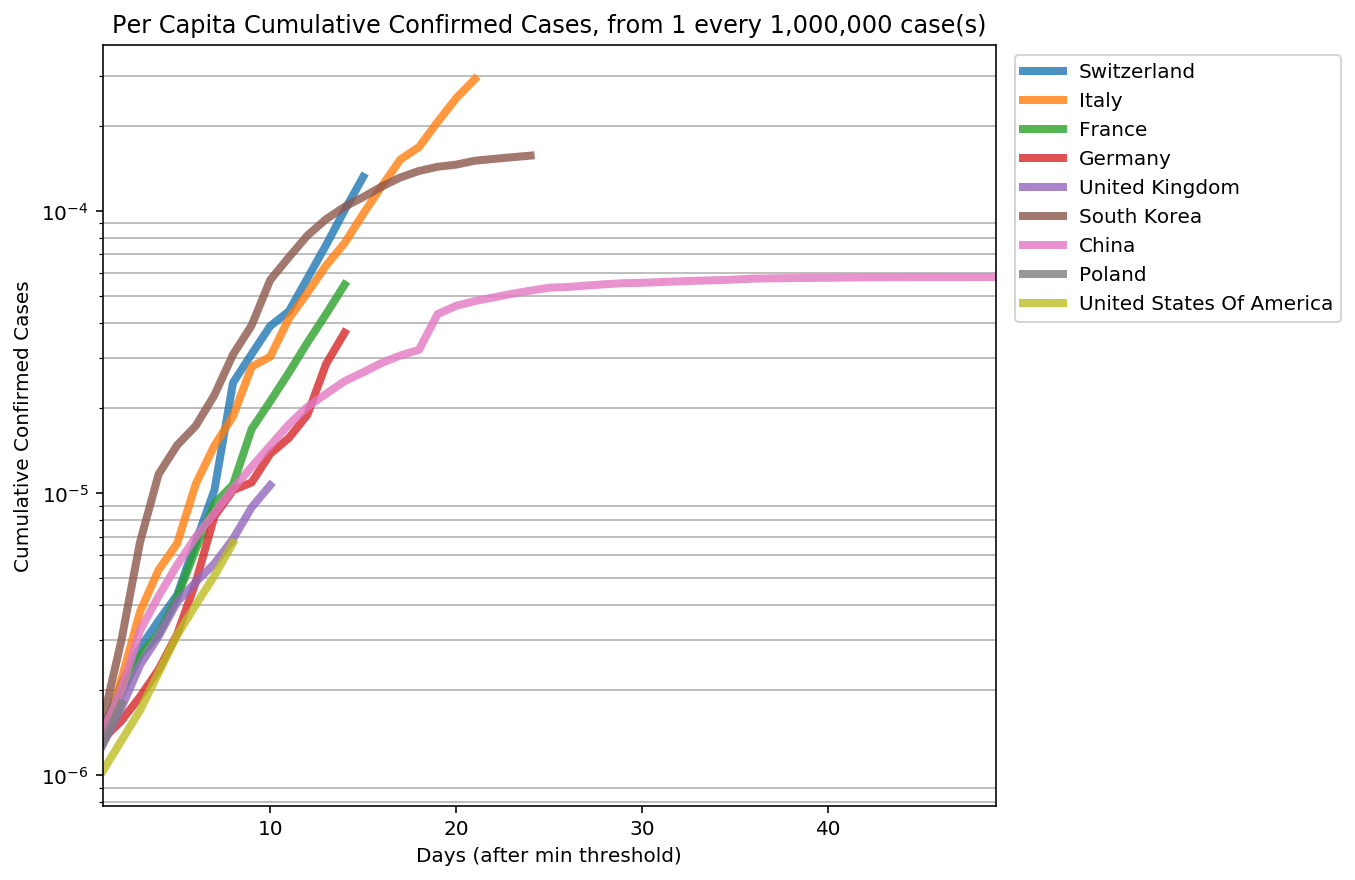

In [133]:
plot_country_dayone(df=w_df, clmn_name='w_NewConfCases', thresh=1e-6)
plt.savefig('./_output/pics/cumsum_cases_capita.png', dpi=120, bbox_inches = 'tight')

'1,000'

## Countries with Highest Confirmed Cases per capita (cumulative)

['San Marino', 'Iceland', 'Italy', 'South Korea', 'Iran', 'Denmark', 'Bahrain', 'Switzerland', 'Norway', 'Qatar', 'Liechtenstein', 'Spain', 'Brunei Darussalam', 'Sweden', 'Slovenia', 'Luxembourg', 'Estonia', 'China', 'Austria', 'France']
Countries with Highest Pro Capita Confirmed Cases


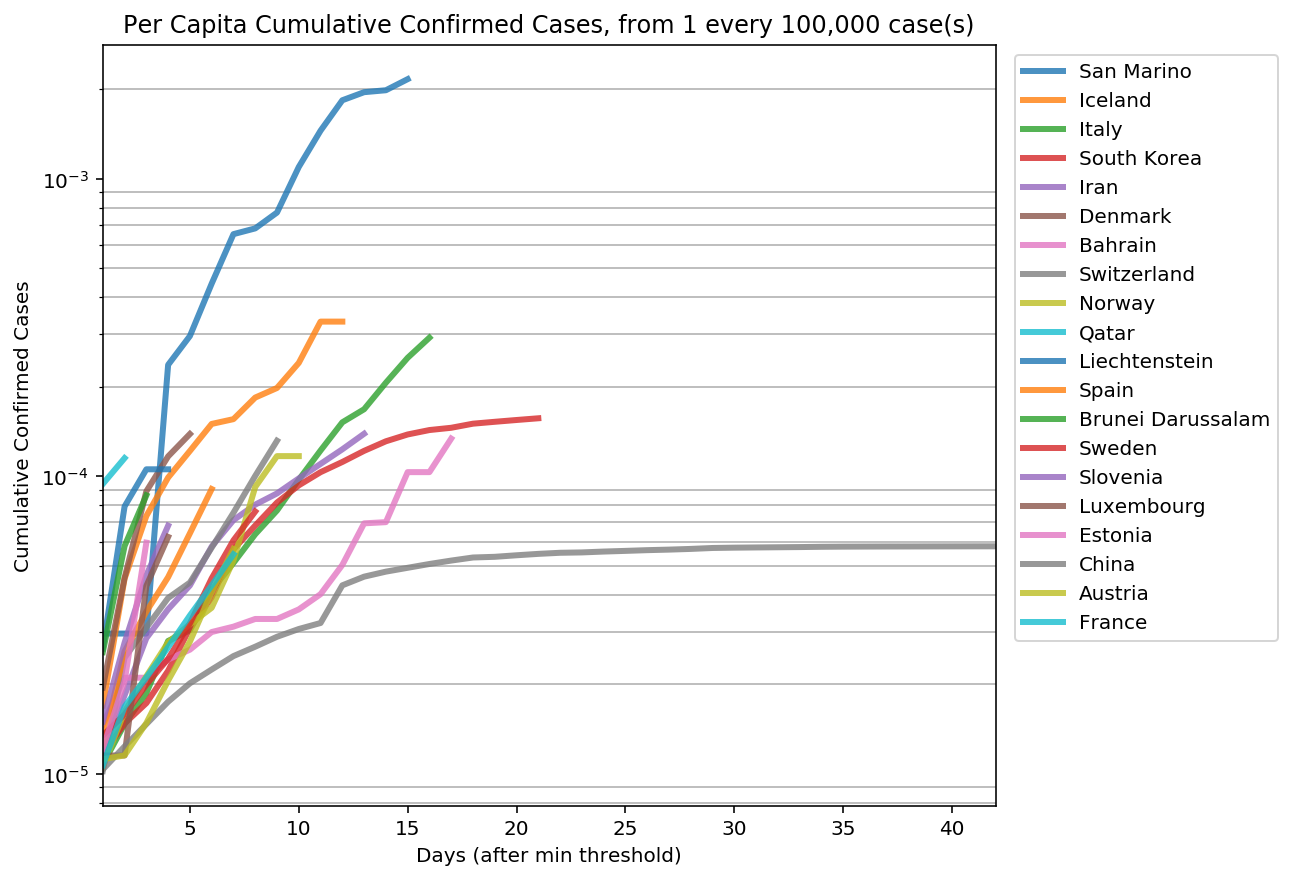

In [134]:
c_num = 20
hi_cumsum_capita = w_df.loc[idx[:,last_av_date],idx['cumsum','w_NewConfCases']].sort_values(ascending=False).head(c_num)
hi_cumsum_capita_lst = hi_cumsum_capita.reset_index()['Country Name'].to_list()
print(hi_cumsum_capita_lst)

plot_country_dayone(df=w_df, clmn_name='w_NewConfCases',  countries=hi_cumsum_capita_lst, thresh=1.e-5, lw=3)
print('Countries with Highest Pro Capita Confirmed Cases')
plt.savefig('./_output/pics/cumsum_cases_capita_high.png', dpi=120, bbox_inches = 'tight')

# Doubling Time